# DETECTING PNEUMONIA IN CHEST X-RAYS USING CONVOLUTIONAL NEURAL NETWORKS
###*ABUBACKER, Mohamed Nafees*
###*CARILLO, Jella Marie*
###*DORVEAUX, Thomas*

---



# Importing the data set

In [0]:
from google.colab import drive
drive = drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import torch
import random
import os
import glob
from skimage import io
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F


## load train, test and validation label arrays


##here put your custom destination folder
train_normal = list(glob.glob(os.path.join("drive/My Drive/Deep Learning Project/chest_xray/train/NORMAL/*.jpeg")))
train_pneu = list(glob.glob(os.path.join("drive/My Drive/Deep Learning Project/chest_xray/train/PNEUMONIA/*.jpeg")))

val_normal = list(glob.glob(os.path.join("drive/My Drive/Deep Learning Project/chest_xray/val/NORMAL/*.jpeg")))
val_pneu = list(glob.glob(os.path.join("drive/My Drive/Deep Learning Project/chest_xray/val/PNEUMONIA/*.jpeg")))

test_normal = list(glob.glob(os.path.join("drive/My Drive/Deep Learning Project/chest_xray/test/NORMAL/*.jpeg")))
test_pneu = list(glob.glob(os.path.join("drive/My Drive/Deep Learning Project/chest_xray/test/PNEUMONIA/*.jpeg")))

# Data segregation

In [0]:
test=test_normal+test_pneu
train=train_normal+train_pneu
val=val_normal+val_pneu

# Data pre-processing

In [0]:
from torch.utils.data.dataset import Dataset
from skimage import io
import numpy as np
import cv2

from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),                            
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
    
class MyDataset(Dataset):
    def __init__(self, image_list,transform=transform):

        ##Load array of images
        self.images = image_list

    def __getitem__(self, index):
        ## Get the image-label set 
        image = io.imread(self.images[index]) 
        #image = np.transpose(image, (2,0,1))
        image = cv2.imread(self.images[index])
        image = cv2.resize(image, (224,224))
        #image = np.array(image)
        if image.shape[2] ==1:
          image = np.dstack([image, image, image])
        #else:
          #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)/255
        if 'PNEUMONIA' in self.images[index]:
            label = 1
        else:
            label = 0
        
        return image, label

    def __len__(self):
        ## return the total number of data samples
        return len(self.images)

# Data loaders

In [0]:
train_data = MyDataset(train,transform=transform)
test_data = MyDataset(test,transform=transform)
val_data = MyDataset(val, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True,drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=False,drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=False,drop_last=True)

# EDA

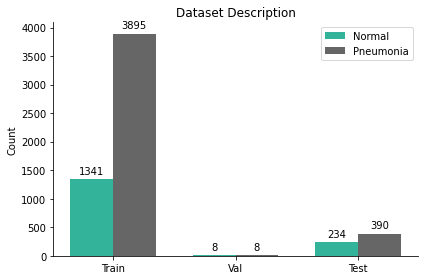

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Train', 'Val','Test']
normal_values = [len(train_normal), len(val_normal),len(test_normal)]
pneumonia_values = [len(train_pneu), len(val_pneu),len(test_pneu)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

rects1 = ax.bar(x - width/2, normal_values, width, label='Normal', color = (0.2,0.7,0.6,1))
rects2 = ax.bar(x + width/2, pneumonia_values, width, label='Pneumonia',color = (0.4,0.4,0.4,1))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Dataset Description')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# AlexNet

In [0]:
import torchvision.models as models
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

alexnet = models.alexnet()

alexnet.fc = nn.Softmax(nn.Linear(1000,2))
#alexnet.softmax1 = nn.Softmax(alexnet.fc)
#alexnet = alexnet.to(device)
model = alexnet.to(device)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 30

In [0]:
t_loss=0.0
val_loss=0.0

loss_lst_AN=[]
v_loss_lst_AN=[]
for epoch in range(epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  t_loss=0.0
  val_loss=0.0
  for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs=np.transpose(inputs, (0,3,1,2))

        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        t_loss+=loss.item()
  with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = data
        
            inputs=np.transpose(inputs, (0,3,1,2))

            inputs=inputs.to(device)
            labels=labels.to(device)
            model.eval()
            outputs = model(inputs)
        # Computes loss
            loss = criterion(outputs, labels)
        # Returns the loss
            val_loss+=loss.item()
            # Switch to evaluation mode
     
  loss_lst_AN.append(t_loss/len(train_dataloader))
  v_loss_lst_AN.append(val_loss/len(val_dataloader))

## Train/Val loss curves

Text(0, 0.5, 'LOSS')

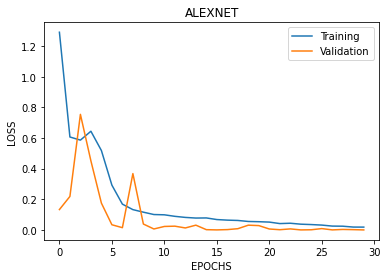

In [0]:
import matplotlib.pyplot as plt
plt_train, = plt.plot(loss_lst_AN, label='Training')
plt_test, = plt.plot(v_loss_lst_AN, label='Validation')
plt.legend(handles=[plt_train, plt_test])
plt.title('ALEXNET')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')


## Saving the model

In [0]:
PATH = 'drive/My Drive/Deep Learning Project/alexnetmodel00.pt'
torch.save(model.state_dict(), PATH)

In [0]:
model.load_state_dict(torch.load('drive/My Drive/Deep Learning Project/alexnetmodel00.pt'))

<All keys matched successfully>

##Test Accuracy

In [0]:
correct, total=0,0
predictions=[]
model.eval()
pred_lab=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=np.transpose(inputs, (0,3,1,2))
        inputs=inputs.to(device)
        labels=labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        _,predicted=torch.max(outputs.data,1)
        for j in predicted:
          a=j.cpu()
          pred_lab.append(a.numpy())
        predictions.append(outputs)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print(100*(correct/total))


81.29032258064515


## Confusion Matrix

In [0]:
x_valid=[]
y_valid=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        x_valid.append(inputs)
        y_valid.append(labels)

In [0]:
test_lab=[]
for i in y_valid:
  for j in i:
    test_lab.append(j.numpy())

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

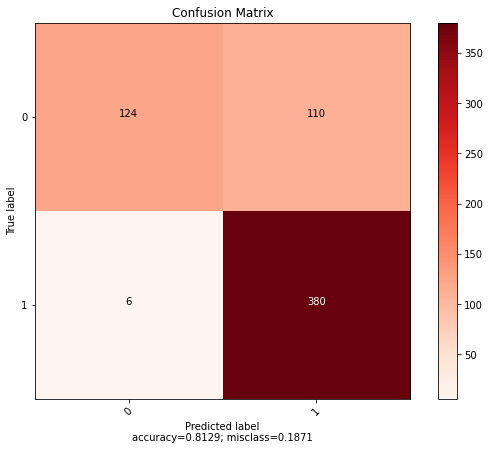

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_lab,pred_lab)
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")

In [0]:
from sklearn.metrics import classification_report

print(classification_report(test_lab,pred_lab))

              precision    recall  f1-score   support

           0       0.95      0.53      0.68       234
           1       0.78      0.98      0.87       386

    accuracy                           0.81       620
   macro avg       0.86      0.76      0.77       620
weighted avg       0.84      0.81      0.80       620



# ResNet 18

In [0]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=True)

### Now set requires_grad to false
for param in model.parameters():
  param.requires_grad = False

#modules = list(model.children())[:-1] # delete the last fc layer.
n_inputs = model.fc.in_features
n_classes = 2

model.fc = nn.Sequential(nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 30

In [0]:
## Train the model and validate it after each epoch.
## Provide the train-val loss graph.

# *****START CODE
t_loss=0.0
val_loss=0.0

loss_lst_AN=[]
v_loss_lst_AN=[]
for epoch in range(epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  t_loss=0.0
  val_loss=0.0
  for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if i % 10 == 0:
          print (i)
        inputs, labels = data
        
        inputs=np.transpose(inputs, (0,3,1,2))

        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        t_loss+=loss.item()
  with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = data
        
            inputs=np.transpose(inputs, (0,3,1,2))

            inputs=inputs.to(device)
            labels=labels.to(device)
            model.eval()
            outputs = model(inputs)
        # Computes loss
            loss = criterion(outputs, labels)
        # Returns the loss
            val_loss+=loss.item()
            # Switch to evaluation mode
     
  loss_lst_AN.append(t_loss/len(train_dataloader))
  v_loss_lst_AN.append(val_loss/len(val_dataloader))
  #v_loss_lst.append(val_loss)
  print('EPOCH:',epoch, '| TRAINING LOSS:',loss_lst_AN[-1], '| VALIDATION LOSS:',v_loss_lst_AN[-1])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 0 | TRAINING LOSS: 0.2146925488913446 | VALIDATION LOSS: 0.19167079031467438
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 1 | TRAINING LOSS: 0.12576511896500642 | VALIDATION LOSS: 0.09270024299621582
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 2 | TRAINING LOSS: 0.10792814734954394 | VALIDATION LOSS: 0.030300259590148926
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
3

## Train/Val loss curves

Text(0, 0.5, 'Loss')

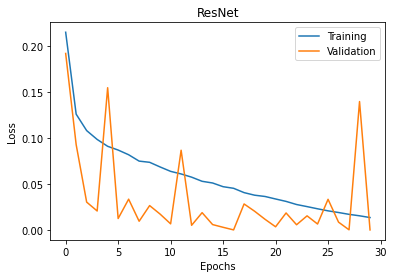

In [0]:
import matplotlib.pyplot as plt
plt_train, = plt.plot(loss_lst_AN, label='Training')
plt_test, = plt.plot(v_loss_lst_AN, label='Validation')
plt.legend(handles=[plt_train, plt_test])
plt.title('ResNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')


## Saving the model

In [0]:
PATH = 'drive/My Drive/Deep Learning Project/resnet1.pt'
torch.save(model.state_dict(), PATH)

##Test Accuracy

In [0]:
correct, total=0,0
predictions=[]
model.eval()
pred_lab=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=np.transpose(inputs, (0,3,1,2))
        inputs=inputs.to(device)
        labels=labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        _,predicted=torch.max(outputs.data,1)
        for j in predicted:
          a=j.cpu()
          pred_lab.append(a.numpy())
        predictions.append(outputs)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print(100*(correct/total))
model.load_state_dict(torch.load('drive/My Drive/Deep Learning Project/resnet1.pt')) 

83.01282051282051


<All keys matched successfully>

## Confusion Matrix

In [0]:
x_valid=[]
y_valid=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        x_valid.append(inputs)
        y_valid.append(labels)

In [0]:
test_lab=[]
for i in y_valid:
  for j in i:
    test_lab.append(j.numpy())

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

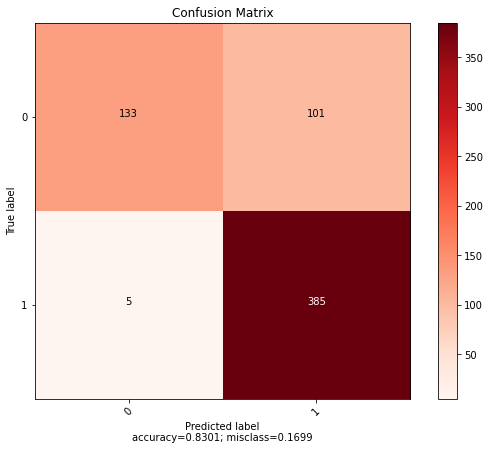

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_lab,pred_lab)
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")

In [0]:
from sklearn.metrics import classification_report
print(classification_report(test_lab, pred_lab))

              precision    recall  f1-score   support

           0       0.96      0.57      0.72       234
           1       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



# VGG 16

In [0]:

import torchvision.models as models
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vgg = models.vgg16(pretrained=True)

vgg.fc = nn.Softmax(nn.Linear(1000,2))

model = vgg.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [0]:
torch.cuda.empty_cache()

In [0]:
t_loss=0.0
val_loss=0.0

loss_lst_AN=[]
v_loss_lst_AN=[]
for epoch in range(epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  t_loss=0.0
  val_loss=0.0
  for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if i % 10 == 0:
          print(i)
        inputs, labels = data
        
        inputs=np.transpose(inputs, (0,3,1,2))

        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize-
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        t_loss+=loss.item()
  with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = data
        
            inputs=np.transpose(inputs, (0,3,1,2))

            inputs=inputs.to(device)
            labels=labels.to(device)
            model.eval()
            outputs = model(inputs)
        # Computes loss
            loss = criterion(outputs, labels)
        # Returns the loss
            val_loss+=loss.item()
            # Switch to evaluation mode
     
  loss_lst_AN.append(t_loss/len(train_dataloader))
  v_loss_lst_AN.append(val_loss/len(val_dataloader))


0


## Train/Val loss curves

Text(0, 0.5, 'LOSS')

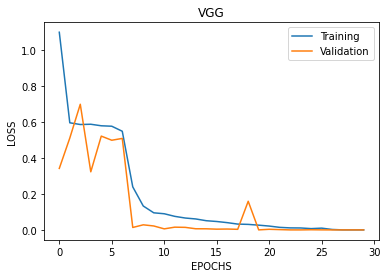

In [0]:
import matplotlib.pyplot as plt
plt_train, = plt.plot(loss_lst_AN, label='Training')
plt_test, = plt.plot(v_loss_lst_AN, label='Validation')
plt.legend(handles=[plt_train, plt_test])
plt.title('VGG')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')


## Saving the model

In [0]:
PATH = 'drive/My Drive/Deep Learning Project/VGG.pt'
torch.save(model.state_dict(), PATH)

# Custom made CNN #1

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=5,stride=1,padding=2)                                              
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.dropout = nn.Dropout(0.2)
        #self.conv3 = nn.Conv2d(64, 128, 5, 1, 2)
        self.fc1 = nn.Linear(200704, 300)
        
        self.fc2 = nn.Linear(300, 10)
    
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x),0.2))
        x = self.pool(F.leaky_relu(self.conv2(x),0.2))
        x = self.dropout(x)
        #x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x= torch.relu(self.fc1(x))            
        output = self.fc2(x)
        return output


In [0]:
import torchvision.models as models
import torch
import torch.nn as nn


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ConvNet()

n_inputs = model.fc1.in_features
n_classes = 2

model.fc = nn.Sequential(nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model = model.to(device)


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 30

In [0]:
## Train the model and validate it after each epoch.
## Provide the train-val loss graph.

# *****START CODE
t_loss=0.0
val_loss=0.0

loss_lst_AN=[]
v_loss_lst_AN=[]
for epoch in range(epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  t_loss=0.0
  val_loss=0.0
  for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if i % 10 == 0:
          print (i)
        inputs, labels = data
        
        inputs=np.transpose(inputs, (0,3,1,2))

        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        t_loss+=loss.item()
  with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = data
        
            inputs=np.transpose(inputs, (0,3,1,2))

            inputs=inputs.to(device)
            labels=labels.to(device)
            model.eval()
            outputs = model(inputs)
        # Computes loss
            loss = criterion(outputs, labels)
        # Returns the loss
            val_loss+=loss.item()
            # Switch to evaluation mode
     
  loss_lst_AN.append(t_loss/len(train_dataloader))
  v_loss_lst_AN.append(val_loss/len(val_dataloader))
  #v_loss_lst.append(val_loss)
  print('EPOCH:',epoch, '| TRAINING LOSS:',loss_lst_AN[-1], '| VALIDATION LOSS:',v_loss_lst_AN[-1])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 0 | TRAINING LOSS: 0.42570035102535464 | VALIDATION LOSS: 0.04733338952064514
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 1 | TRAINING LOSS: 0.1603575019226525 | VALIDATION LOSS: 0.004909164272248745
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 2 | TRAINING LOSS: 0.11693242590102182 | VALIDATION LOSS: 0.017545754089951515
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370


## Train/Val loss curves

Text(0, 0.5, 'Loss')

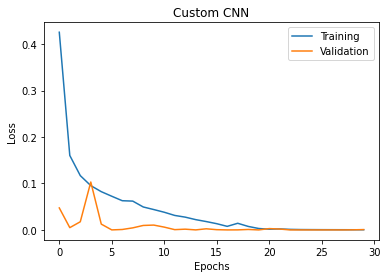

In [0]:
import matplotlib.pyplot as plt
plt_train, = plt.plot(loss_lst_AN, label='Training')
plt_test, = plt.plot(v_loss_lst_AN, label='Validation')
plt.legend(handles=[plt_train, plt_test])
plt.title('Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Saving the model

In [0]:
PATH = 'drive/My Drive/Deep Learning Project/customcnn_nafees.pt'
torch.save(model.state_dict(), PATH)

##Test Accuracy

In [0]:
correct, total=0,0
predictions=[]
model.eval()
pred_lab=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=np.transpose(inputs, (0,3,1,2))
        inputs=inputs.to(device)
        labels=labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        _,predicted=torch.max(outputs.data,1)
        for j in predicted:
          a=j.cpu()
          pred_lab.append(a.numpy())
        predictions.append(outputs)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print(100*(correct/total))

73.87820512820514


## Confusion Matrix

In [0]:
x_valid=[]
y_valid=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        x_valid.append(inputs)
        y_valid.append(labels)

In [0]:
test_lab=[]
for i in y_valid:
  for j in i:
    test_lab.append(j.numpy())

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

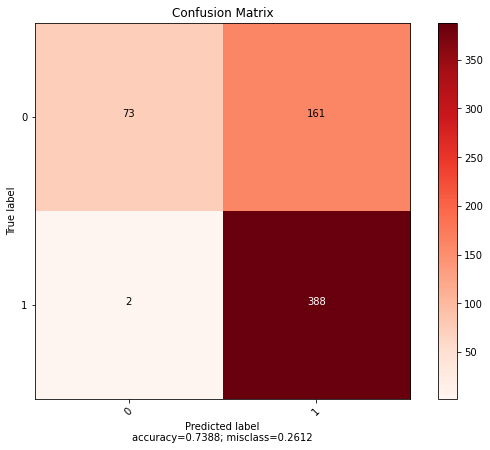

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_lab,pred_lab)
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")

In [0]:
from sklearn.metrics import classification_report

print(classification_report(test_lab,pred_lab))

              precision    recall  f1-score   support

           0       0.97      0.31      0.47       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.65       624
weighted avg       0.81      0.74      0.69       624

ERROR! Session/line number was not unique in database. History logging moved to new session 61


# Custom made CNN #2

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5,stride=1,padding=2)                                              
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        #self.conv3 = nn.Conv2d(32, 128, 5, 1, 2)
        self.fc1 = nn.Linear(100352, 10)
    
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)     
        output = self.fc1(x)
        return output


In [0]:
import torchvision.models as models
import torch
import torch.nn as nn


device =  'cpu' #'cuda' if torch.cuda.is_available() else

model = ConvNet()

n_inputs = model.fc1.in_features
n_classes = 2

model.fc = nn.Sequential(nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model = model.to(device)


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 30

In [0]:
## Train the model and validate it after each epoch.
## Provide the train-val loss graph.

# *****START CODE
t_loss=0.0
val_loss=0.0

loss_lst_AN=[]
v_loss_lst_AN=[]
for epoch in range(epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  t_loss=0.0
  val_loss=0.0
  for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if i % 10 == 0:
          print (i)
        inputs, labels = data
        
        inputs=np.transpose(inputs, (0,3,1,2))

        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        t_loss+=loss.item()
  with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = data
        
            inputs=np.transpose(inputs, (0,3,1,2))

            inputs=inputs.to(device)
            labels=labels.to(device)
            model.eval()
            outputs = model(inputs)
        # Computes loss
            loss = criterion(outputs, labels)
        # Returns the loss
            val_loss+=loss.item()
            # Switch to evaluation mode
     
  loss_lst_AN.append(t_loss/len(train_dataloader))
  v_loss_lst_AN.append(val_loss/len(val_dataloader))
  #v_loss_lst.append(val_loss)
  print('EPOCH:',epoch, '| TRAINING LOSS:',loss_lst_AN[-1], '| VALIDATION LOSS:',v_loss_lst_AN[-1])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 0 | TRAINING LOSS: 0.40977554440850267 | VALIDATION LOSS: 0.01896190643310547
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 1 | TRAINING LOSS: 0.15561018160562998 | VALIDATION LOSS: 0.2823561728000641
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
EPOCH: 2 | TRAINING LOSS: 0.10261161218326004 | VALIDATION LOSS: 0.0002627372741699219
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370


## Train/Val loss curves

Text(0, 0.5, 'Loss')

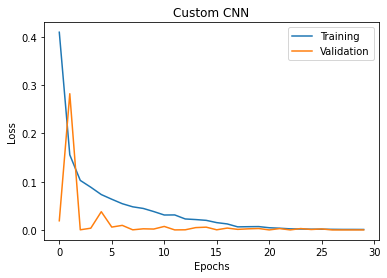

In [0]:
import matplotlib.pyplot as plt
plt_train, = plt.plot(loss_lst_AN, label='Training')
plt_test, = plt.plot(v_loss_lst_AN, label='Validation')
plt.legend(handles=[plt_train, plt_test])
plt.title('Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Saving the model

In [0]:
PATH = 'drive/My Drive/Deep Learning Project/customcnn_jella.pt'
torch.save(model.state_dict(), PATH))

##Test Accuracy

In [0]:
correct, total=0,0
predictions=[]
model.eval()
pred_lab=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=np.transpose(inputs, (0,3,1,2))
        inputs=inputs.to(device)
        labels=labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        _,predicted=torch.max(outputs.data,1)
        for j in predicted:
          a=j.cpu()
          pred_lab.append(a.numpy())
        predictions.append(outputs)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print(100*(correct/total))


74.35897435897436


## Confusion Matrix

In [0]:
x_valid=[]
y_valid=[]
for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        x_valid.append(inputs)
        y_valid.append(labels)

In [0]:
test_lab=[]
for i in y_valid:
  for j in i:
    test_lab.append(j.numpy())

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

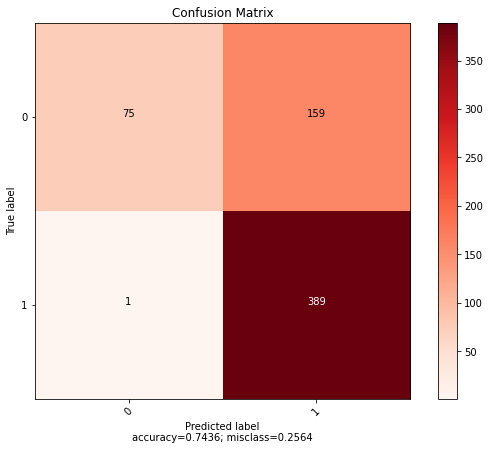

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_lab,pred_lab)
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")

In [0]:
from sklearn.metrics import classification_report

print(classification_report(test_lab,pred_lab))

              precision    recall  f1-score   support

           0       0.99      0.32      0.48       234
           1       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624

